In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scorers import compute_scores
from functools import partial
from itertools import combinations

from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector, IntVector
pROC = importr("pROC")

LATEX = False

In [2]:
def prevalence(df):
    print(
        f"N={len(df)} ({df.true_label.notna().mean()*100:2.1f}%)"
    )
    print(df.true_label.value_counts(dropna=False))

# Analysis

In [3]:
main_cohort = pd.read_csv(COHORT_DATA_FILE)

main_cohort["pfizer_pred_filled_0"] = main_cohort.pfizer_prediction.fillna(0)
main_cohort["enet_pred_filled_0"] = main_cohort.echonet_prediction.fillna(0)
main_cohort["enet_preds_proba"] = main_cohort.echonet_prediction.apply(lambda x: np.array([1 - x, x]))
main_cohort["enet_filled_0_preds_proba"] = main_cohort["enet_pred_filled_0"].apply(
    lambda x: np.array([1 - x, x])
)
main_cohort["ult_filled_0"] = main_cohort.ultromics_classification.fillna(0)
main_cohort["ult_preds_proba"] = main_cohort.ultromics_prediction.apply(lambda x: np.array([1 - x, x]))
main_cohort["ult_filled_0_preds_proba"] = main_cohort["ult_filled_0"].apply(
    lambda x: np.array([1 - x, x])
)

## Main Table 3

Main analytical cohort, performance where there are predictions for all models. Any study which failed to produce a result from either EchoNet-LVH or Ultromics EchoGO is dropped.

In [5]:
mask_both = (
    main_cohort.echonet_prediction.notna() & 
    main_cohort.ultromics_prediction.notna()
    & (main_cohort.ultromics_classification != "Uncertain")
)

cohort_tbl_3 = main_cohort.loc[mask_both]

In [6]:
CI_score = partial(
    compute_scores,
    y_true=cohort_tbl_3.true_label.notna().values,
    auc_conf=(2.5, 97.5),
    ap_conf=(2.5, 97.5),
    ci_conf=(2.5, 97.5),
)

table3_perf = pd.DataFrame(
    [
        CI_score(
            y_pred=cohort_tbl_3.preds.apply(lambda x: x >= 0.5).values,
            y_pred_proba=np.vstack(cohort_tbl_3.pfizer_pred_filled_0.values),
        ),
        CI_score(
            y_pred=cohort_tbl_3.mayo_score.apply(lambda x: x >= 6).values,
            y_pred_proba=np.vstack(
                [
                    np.zeros_like(cohort_tbl_3.mayo_score.values),
                    cohort_tbl_3.mayo_score.values,
                ]
            ).T,
        ),
        CI_score(
            y_pred=cohort_tbl_3.echonet_prediction.apply(lambda x: x >= 0.8).values,
            y_pred_proba=np.vstack(cohort_tbl_3.enet_preds_proba.values),
        ),
        CI_score(
            y_pred=(
                cohort_tbl_3.ultromics_classification == "DetectedAmyloidosis"
            ).values,
            y_pred_proba=np.vstack(cohort_tbl_3.ult_preds_proba.values),
        ),
    ],
    index=["\pfizertable", "\mayotable", "\enettable", "\\ulttable"],
)

In [7]:
table3_perf[
    [
        "f1_score",
        "accuracy",
        "sensitivity",
        "specificity",
        "ppv",
        "npv",
        "fnr",
        "pr_auc",
        "roc_auc",
        "auc_CI",
        "ap_CI",
    ]
].round(2)

,f1_score,accuracy,sensitivity,specificity,ppv,npv,fnr,pr_auc,roc_auc,auc_CI,ap_CI
\pfizertable,0.09,0.66,0.34,0.68,0.05,0.95,0.66,0.06,0.49,"[0.44, 0.54]","[0.05, 0.08]"
\mayotable,0.31,0.85,0.65,0.86,0.20,0.98,0.35,0.16,0.79,"[0.76, 0.83]","[0.14, 0.2]"
\enettable,0.61,0.96,0.57,0.98,0.66,0.98,0.43,0.62,0.88,"[0.85, 0.91]","[0.55, 0.69]"
\ulttable,0.49,0.91,0.85,0.91,0.34,0.99,0.15,0.67,0.92,"[0.89, 0.94]","[0.6, 0.73]"


In [8]:
table3_perf[
    [
        "f1_score_CI",
        "accuracy_CI",
        "sensitivity_CI",
        "specificity_CI",
        "ppv_CI",
        "npv_CI",
        "fnr_CI",
    ]
].round(2)

,f1_score_CI,accuracy_CI,sensitivity_CI,specificity_CI,ppv_CI,npv_CI,fnr_CI
\pfizertable,"[0.07, 0.11]","[0.64, 0.68]","[0.27, 0.41]","[0.66, 0.69]","[0.04, 0.07]","[0.94, 0.96]","[0.6, 0.74]"
\mayotable,"[0.26, 0.35]","[0.84, 0.86]","[0.58, 0.73]","[0.85, 0.87]","[0.17, 0.24]","[0.97, 0.98]","[0.28, 0.42]"
\enettable,"[0.54, 0.67]","[0.96, 0.97]","[0.5, 0.63]","[0.98, 0.99]","[0.59, 0.74]","[0.97, 0.98]","[0.36, 0.51]"
\ulttable,"[0.44, 0.54]","[0.9, 0.92]","[0.8, 0.9]","[0.9, 0.92]","[0.3, 0.39]","[0.99, 0.99]","[0.1, 0.2]"


In [9]:
prevalence(cohort_tbl_3)

# Pairwise DeLong ROC test
for (label1, col1), (label2, col2) in combinations(
    [
        ("Mayo", cohort_tbl_3.mayo_score.values),
        ("Echonet", cohort_tbl_3.echonet_prediction),
        ("Ultromics", cohort_tbl_3.ultromics_prediction),
    ],
    2,
):
    true1 = IntVector(
        cohort_tbl_3.true_label.notna().values.astype(int)
    )
    roc1 = pROC.roc(true1, FloatVector(col1), quiet=True)
    roc2 = pROC.roc(true1, FloatVector(col2), quiet=True)

    Rdelong = pROC.roc_test(
        roc1, roc2, paried=True, method="delong", alternative="two.sided"
    )

    print(
        f"Delong Roc Test between {label1} and {label2}: {Rdelong.rx2('p.value')[0]:.5}"
    )

N=3368 (5.2%)
label__amyloid_subtype_diagnosis
None    3192
TTR      176
Name: count, dtype: int64
Delong Roc Test between Mayo and Echonet: 0.00018171
Delong Roc Test between Mayo and Ultromics: 1.4721e-10
Delong Roc Test between Echonet and Ultromics: 0.015813


## Main Table 4
with moderate or greater LVH

Performance of various models on patients with at least moderate LVH as defined by posterior wall thickness ≥1.4 for men, ≥ 1.3 for women

In [10]:
"""
Male (Sex = 0.0)
    Normal: 0.6 - 1.1
    Mild: 1.1 - 1.4
    Moderate: 1.4 - 1.7
    Severe: 1.7 - inf
Female (Sex = 1.0)
    Normal: 0.6 - 1.0
    Mild: 1.0 - 1.3
    Moderate: 1.3 - 1.6
    Severe: 1.6 - inf
"""

cohort_tbl_4 = cohort_tbl_3.copy(deep=True)
amyl_pat_ids = cohort_tbl_3.loc[cohort_tbl_3.true_label.notna(), "id"]

ENCODE = True  # Use binary encoding for at least moderate or actual value.
# EDIT these with desired sex based cutoffs
lvh_def = {
    "None": {0.0: [0.0, 1.1], 1.0: [0.0, 1.0], "encode": False},
    "mild": {0.0: [1.1, 1.4], 1.0: [1.0, 1.3], "encode": False},
    "mod": {0.0: [1.4, 1.7], 1.0: [1.3, 1.6], "encode": True},
    "sev": {0.0: [1.7, np.inf], 1.0: [1.6, np.inf], "encode": True},
}
for key, value in lvh_def.items():
    cohort_tbl_4.loc[
        cohort_tbl_4.apply(
            lambda row: value[row.Sex][0] <= row.PWT < value[row.Sex][1],
            axis=1,
        ),
        "lvh_bin",
    ] = (
        value["encode"] if ENCODE else key
    )

In [11]:
y_true = (
    cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "true_label"]
    .notna()
    .values
)
table4_perf = pd.DataFrame(
    [
        compute_scores(
            y_true=y_true,
            y_pred=cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "mayo_score"]
            .apply(lambda x: x >= 6)
            .values,
            y_pred_proba=np.vstack(
                [
                    np.zeros_like(
                        cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "mayo_score"].values
                    ),
                    cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "mayo_score"].values,
                ]
            ).T,
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
            ci_conf=(2.5, 97.5),
        ),
        compute_scores(
            y_true=y_true,
            y_pred=cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "amyloid_pred_filled_0"]
            .apply(lambda x: x >= 0.8)
            .values,
            y_pred_proba=np.vstack(
                cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "enet_filled_0_preds_proba"].values
            ),
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
            ci_conf=(2.5, 97.5),
        ),
        compute_scores(
            y_true=y_true,
            y_pred=(
                cohort_tbl_4.loc[
                    cohort_tbl_4.lvh_bin,
                    "ultromics_classification",
                ]
                == "DetectedAmyloidosis"
            ).values,
            y_pred_proba=np.vstack(
                cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "ult_preds_proba"].values
            ),
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
            ci_conf=(2.5, 97.5),
        ),
    ],
    index=[
        "\mayotable-mod-sev",
        "\enettable-mod-sev",
        r"\ulttable-mod-sev",
    ],
)

In [12]:
table4_perf[
    [
        "f1_score",
        "accuracy",
        "sensitivity",
        "specificity",
        "pr_auc",
        "roc_auc",
        "ap_CI",
        "auc_CI"
    ]
].round(2)

,f1_score,accuracy,sensitivity,specificity,pr_auc,roc_auc,ap_CI,auc_CI
\mayotable-mod-sev,0.44,0.50,0.82,0.40,0.28,0.60,"[0.24, 0.33]","[0.54, 0.65]"
\enettable-mod-sev,0.74,0.89,0.66,0.96,0.81,0.91,"[0.74, 0.88]","[0.88, 0.94]"
\ulttable-mod-sev,0.77,0.87,0.92,0.85,0.83,0.93,"[0.76, 0.89]","[0.9, 0.95]"


In [13]:
table4_perf[
    [
        "f1_score_CI",
        "accuracy_CI",
        "sensitivity_CI",
        "specificity_CI",
        "ppv_CI",
        "npv_CI",
        "fnr_CI",
    ]
]

,f1_score_CI,accuracy_CI,sensitivity_CI,specificity_CI,ppv_CI,npv_CI,fnr_CI
\mayotable-mod-sev,"[0.38, 0.5]","[0.46, 0.54]","[0.74, 0.88]","[0.35, 0.45]","[0.25, 0.35]","[0.83, 0.92]","[0.12, 0.25]"
\enettable-mod-sev,"[0.67, 0.8]","[0.86, 0.92]","[0.57, 0.74]","[0.94, 0.98]","[0.76, 0.91]","[0.87, 0.93]","[0.26, 0.43]"
\ulttable-mod-sev,"[0.71, 0.82]","[0.84, 0.9]","[0.86, 0.96]","[0.81, 0.88]","[0.59, 0.73]","[0.95, 0.99]","[0.04, 0.13]"


In [14]:
prevalence(cohort_tbl_4[cohort_tbl_4.lvh_bin])

for (label1, col1), (label2, col2) in combinations(
    [
        ("Mayo", cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "mayo_score"].values),
        ("Echonet_0", cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "enet_pred_filled_0"]),
        ("Ultromics_0", cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "ult_pred_filled_0"]),
    ],
    2,
):
    true1 = IntVector(
        cohort_tbl_4.loc[cohort_tbl_4.lvh_bin, "true_label"]
        .notna()
        .values.astype(int)
    )
    roc1 = pROC.roc(true1, FloatVector(col1), quiet=True)
    roc2 = pROC.roc(true1, FloatVector(col2), quiet=True)

    Rdelong = pROC.roc_test(
        roc1, roc2, paried=True, method="delong", alternative="two.sided"
    )

    print(
        f"Delong Roc Test between {label1} and {label2}: {Rdelong.rx2('p.value')[0]:.5}"
    )

N=504 (23.8%)
label__amyloid_subtype_diagnosis
None    384
TTR     120
Name: count, dtype: int64
Delong Roc Test between Mayo and Echonet_0: 5.9594e-25
Delong Roc Test between Mayo and Ultromics_0: 1.2675e-28
Delong Roc Test between Echonet_0 and Ultromics_0: 0.32279


## Main Table 5
LVEF < 40% at echo

In [15]:
mask_tbl_5 = (
    main_cohort.echonet_predictions.notna()
    & main_cohort.ultromics_classification.notna()
    & (main_cohort.ultromics_classification != "Uncertain")
    & (main_cohort.EF_fill_custom < 40)
)
cohort_tbl_5 = main_cohort.loc[mask_tbl_5]
y_true_ef_lt = cohort_tbl_5["true_label"].notna().values

perf = pd.DataFrame(
    [
        compute_scores(
            y_true=y_true_ef_lt,
            y_pred=cohort_tbl_5.mayo_score.apply(lambda x: x >= 6).values,
            y_pred_proba=np.vstack(
                [
                    np.zeros_like(cohort_tbl_5.mayo_score.values),
                    cohort_tbl_5.mayo_score.values,
                ]
            ).T,
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
            ci_conf=(2.5, 97.5),
        ),
        compute_scores(
            y_true=y_true_ef_lt,
            y_pred=cohort_tbl_5.echonet_prediction.apply(lambda x: x >= 0.8).values,
            y_pred_proba=np.vstack(cohort_tbl_5.enet_preds_proba.values),
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
            ci_conf=(2.5, 97.5),
        ),
        compute_scores(
            y_true=y_true_ef_lt,
            y_pred=(
                cohort_tbl_5.ultromics_classification == "DetectedAmyloidosis"
            ).values,
            y_pred_proba=np.vstack(cohort_tbl_5.ult_preds_proba.values),
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
            ci_conf=(2.5, 97.5),
        ),
    ],
    index=["\mayotable", "\enettable", r"\ulttable"],
)

perf[
    [
        "f1_score",
        "accuracy",
        "sensitivity",
        "specificity",
        "pr_auc",
        "roc_auc",
        "ap_CI",
        "auc_CI",
    ]
].round(2)

,f1_score,accuracy,sensitivity,specificity,pr_auc,roc_auc,ap_CI,auc_CI
\mayotable,0.42,0.91,0.71,0.92,0.24,0.83,"[0.15, 0.38]","[0.75, 0.9]"
\enettable,0.61,0.96,0.59,0.98,0.65,0.88,"[0.49, 0.79]","[0.8, 0.94]"
\ulttable,0.39,0.88,0.82,0.88,0.67,0.89,"[0.5, 0.82]","[0.8, 0.96]"


In [16]:
perf[
    [
        "f1_score_CI",
        "accuracy_CI",
        "sensitivity_CI",
        "specificity_CI",
        "ppv_CI",
        "npv_CI",
        "fnr_CI",
    ]
]

,f1_score_CI,accuracy_CI,sensitivity_CI,specificity_CI,ppv_CI,npv_CI,fnr_CI
\mayotable,"[0.3, 0.52]","[0.89, 0.93]","[0.54, 0.86]","[0.9, 0.94]","[0.19, 0.39]","[0.97, 0.99]","[0.14, 0.47]"
\enettable,"[0.46, 0.73]","[0.95, 0.98]","[0.41, 0.74]","[0.97, 0.99]","[0.44, 0.8]","[0.97, 0.99]","[0.25, 0.57]"
\ulttable,"[0.29, 0.48]","[0.85, 0.9]","[0.7, 0.95]","[0.85, 0.9]","[0.17, 0.32]","[0.98, 1.0]","[0.06, 0.31]"


In [17]:
prevalence(cohort_tbl_5)

for (label1, col1), (label2, col2) in combinations(
    [
        ("Mayo", cohort_tbl_5.mayo_score.values),
        ("Echonet_0", cohort_tbl_5.echonet_prediction),
        ("Ultromics_0", cohort_tbl_5.ultromics_prediction),
    ],
    2,
):
    true1 = IntVector(
        cohort_tbl_5.true_label
        .notna()
        .values.astype(int)
    )
    roc1 = pROC.roc(true1, FloatVector(col1), quiet=True)
    roc2 = pROC.roc(true1, FloatVector(col2), quiet=True)

    Rdelong = pROC.roc_test(
        roc1, roc2, paried=True, method="delong", alternative="two.sided"
    )

    print(
        f"Delong Roc Test between {label1} and {label2}: {Rdelong.rx2('p.value')[0]:.5}"
    )
    

N=713 (4.8%)
label__amyloid_subtype_diagnosis
None    679
TTR      34
Name: count, dtype: int64
Delong Roc Test between Mayo and Echonet_0: 0.40063
Delong Roc Test between Mayo and Ultromics_0: 0.27941
Delong Roc Test between Echonet_0 and Ultromics_0: 0.80259


## Supp Table 4
Different thresholds

In [18]:
main_cohort["label"] = main_cohort.true_label.notna()

# In built Ultromics EchoGO usues 0.06 as cutoff
main_cohort["least_uncertain_006_cls"] = main_cohort.apply(
    lambda row: (
        row["ultromics_cls_list"][
            np.argmin(row["ultromics_uncertainty_list"])
        ]
        if isinstance(row["ultromics_uncertainty_list"], np.ndarray)
        else float("nan")
    ),
    axis=1,
)
main_cohort["least_uncertain_006_prob"] = main_cohort.apply(
    # index probability detected using prediction uncertainty
    lambda row: (
        row["ultromics_prob_list"][
            np.argmin(row["ultromics_uncertainty_list"])
        ]
        if isinstance(row["ultromics_uncertainty_list"], np.ndarray)
        else float("nan")
    ),
    axis=1,
)

def least_uncertain(row, threshold=0.8):
    # function returns class, probability
    if not isinstance(row["ultromics_uncertainty_list"], np.ndarray):
        # missing ultromics prediction
        return None, float("nan")
    idxmin = np.argmin(row["ultromics_uncertainty_list"])
    prob = row["ultromics_prob_list"][idxmin]

    # check if uncertain:
    if row["ultromics_cls_list"][idxmin] == "Uncertain":
        pred_cls = "Uncertain"
    else:
        pred_cls = (
            "DetectedAmyloidosis"
            if prob >= threshold
            else "NotDetectedAmyloidosis"
        )
    return pred_cls, prob

# least uncertain with 0.8 cutoff
THRESHOLD = 0.8
main_cohort[["least_uncertain_08_cls", "least_uncertain_08_prob"]] = main_cohort.apply(
    least_uncertain, threshold=THRESHOLD, axis=1, result_type="expand"
)
main_cohort["least_uncertain_08_cls_uncertain"] = main_cohort.apply(
    lambda row: (
        (
            "DetectedAmyloidosis"
            if row["least_uncertain_08_prob"] >= THRESHOLD
            else "NotDetectedAmyloidosis"
        )
        if not pd.isna(row["least_uncertain_08_cls"])
        else float("nan")
    ),
    axis=1,
)
# least uncertain with 0.5 cutoff
THRESHOLD = 0.5
main_cohort[["least_uncertain_05_cls", "least_uncertain_05_prob"]] = main_cohort.apply(
    least_uncertain, threshold=THRESHOLD, axis=1, result_type="expand"
)
main_cohort["least_uncertain_05_cls_uncertain"] = main_cohort.apply(
    lambda row: (
        (
            "DetectedAmyloidosis"
            if row["least_uncertain_05_prob"] >= THRESHOLD
            else "NotDetectedAmyloidosis"
        )
        if not pd.isna(row["least_uncertain_05_cls"])
        else float("nan")
    ),
    axis=1,
)

In [25]:
# Cohort where Ult made prediction (dropped uncertain)
scores = []
prevs = []
for ult_cls_col, prob_col, thresh in [
    ("least_uncertain_006_cls", "least_uncertain_006_prob", 0.06),
    ("least_uncertain_05_cls", "least_uncertain_05_prob", 0.5),
    ("least_uncertain_08_cls", "least_uncertain_08_prob", 0.8),
]:
    mask = (main_cohort[ult_cls_col].notna() & (main_cohort[ult_cls_col] != "Uncertain"))
    print(ult_cls_col)
    prevalence(main_cohort.loc[mask])
    scores.append(
        compute_scores(
            y_true=main_cohort.loc[mask, "label"].values,
            y_pred=(main_cohort.loc[mask, ult_cls_col] == "DetectedAmyloidosis").values,
            y_pred_proba=np.vstack(
                [
                    np.ones_like(main_cohort.loc[mask, prob_col].values) - main_cohort.loc[mask, prob_col].values,
                    main_cohort.loc[mask, prob_col].values,
                ]
            ).T,
            ci_conf=(2.5,97.5),
        )
    )
    
    
perf = pd.DataFrame(
    scores,
    index=[
        "least uncertain 0.06",
        "least uncertain 0.5",
        "least uncertain 0.8",
    ],
)
perf[
    [
        "f1_score",
        "accuracy",
        "sensitivity",
        "specificity",
        "ppv",
        "npv",
        "fnr",
    ]
].round(2)

least_uncertain_006_cls
N=4020 (5.2%)
label__amyloid_subtype_diagnosis
None    3811
TTR      209
Name: count, dtype: int64
least_uncertain_05_cls
N=4020 (5.2%)
label__amyloid_subtype_diagnosis
None    3811
TTR      209
Name: count, dtype: int64
least_uncertain_08_cls
N=4020 (5.2%)
label__amyloid_subtype_diagnosis
None    3811
TTR      209
Name: count, dtype: int64


,f1_score,accuracy,sensitivity,specificity,ppv,npv,fnr
least uncertain 0.06,0.47,0.90,0.85,0.90,0.33,0.99,0.15
least uncertain 0.5,0.55,0.93,0.81,0.94,0.42,0.99,0.19
least uncertain 0.8,0.65,0.96,0.66,0.98,0.64,0.98,0.34


In [20]:
perf[
    [
        "f1_score_CI",
        "accuracy_CI",
        "sensitivity_CI",
        "specificity_CI",
        "ppv_CI",
        "npv_CI",
        "fnr_CI",
    ]
]

,f1_score_CI,accuracy_CI,sensitivity_CI,specificity_CI,ppv_CI,npv_CI,fnr_CI
least uncertain 0.06,"[0.42, 0.52]","[0.89, 0.91]","[0.8, 0.89]","[0.9, 0.91]","[0.29, 0.37]","[0.99, 0.99]","[0.11, 0.2]"
least uncertain 0.5,"[0.5, 0.6]","[0.92, 0.94]","[0.75, 0.86]","[0.93, 0.95]","[0.37, 0.47]","[0.99, 0.99]","[0.14, 0.25]"
least uncertain 0.8,"[0.59, 0.7]","[0.96, 0.97]","[0.6, 0.73]","[0.97, 0.98]","[0.58, 0.71]","[0.98, 0.99]","[0.27, 0.4]"


In [21]:
# Where EchoNet and Ultromics EchoGO made predictions (uncertain dropped)
scores = []
prevs = []

for ult_cls_col, prob_col, thresh in [
    ("least_uncertain_006_cls", "least_uncertain_006_prob", 0.06),
    ("least_uncertain_05_cls", "least_uncertain_05_prob", 0.5),
    ("least_uncertain_08_cls", "least_uncertain_08_prob", 0.8),
]:
    mask = (
        main_cohort.amyloid_pred.notna()
        & main_cohort[ult_cls_col].notna()
        & (main_cohort[ult_cls_col] != "Uncertain")
    )
    print(ult_cls_col)
    prevalence(main_cohort.loc[mask])
    scores.append(
        compute_scores(
            y_true=main_cohort.loc[mask, "label"].values,
            y_pred=(main_cohort.loc[mask, "amyloid_pred"] >= thresh).values,
            y_pred_proba=np.vstack(main_cohort.loc[mask, "enet_preds_proba"].values),
            ci_conf=(2.5,97.5),
        )
    )
    scores.append(
        compute_scores(
            y_true=main_cohort.loc[mask, "label"].values,
            y_pred=(main_cohort.loc[mask, ult_cls_col] == "DetectedAmyloidosis").values,
            y_pred_proba=np.vstack(
                [
                    np.ones_like(main_cohort.loc[mask, prob_col].values) - main_cohort.loc[mask, prob_col].values,
                    main_cohort.loc[mask, prob_col].values,
                ]
            ).T,
            ci_conf=(2.5,97.5),
        )
    )

perf = pd.DataFrame(
    scores,
    index=[
        "Echonet 0.06",
        "Ultromics least uncertain 0.06",
        "Echonet 0.5",
        "Ultromics least uncertain 0.5",
        "Echonet 0.8",
        "Ultromics least uncertain 0.8",
    ],
)
perf[
    [
        "f1_score",
        "accuracy",
        "sensitivity",
        "specificity",
        "ppv",
        "npv",
        "fnr",
    ]
].round(2)

least_uncertain_006_cls
N=3368 (5.2%)
label__amyloid_subtype_diagnosis
None    3192
TTR      176
Name: count, dtype: int64
least_uncertain_05_cls
N=3368 (5.2%)
label__amyloid_subtype_diagnosis
None    3192
TTR      176
Name: count, dtype: int64
least_uncertain_08_cls
N=3368 (5.2%)
label__amyloid_subtype_diagnosis
None    3192
TTR      176
Name: count, dtype: int64


,f1_score,accuracy,sensitivity,specificity,ppv,npv,fnr
Echonet 0.06,0.25,0.75,0.83,0.74,0.15,0.99,0.17
Ultromics least uncertain 0.06,0.49,0.91,0.85,0.91,0.34,0.99,0.15
Echonet 0.5,0.54,0.94,0.64,0.96,0.47,0.98,0.36
Ultromics least uncertain 0.5,0.55,0.93,0.81,0.94,0.42,0.99,0.19
Echonet 0.8,0.61,0.96,0.57,0.98,0.66,0.98,0.43
Ultromics least uncertain 0.8,0.64,0.96,0.65,0.98,0.64,0.98,0.35


In [22]:
perf[
    [
        "f1_score_CI",
        "accuracy_CI",
        "sensitivity_CI",
        "specificity_CI",
        "ppv_CI",
        "npv_CI",
        "fnr_CI",
    ]
]

,f1_score_CI,accuracy_CI,sensitivity_CI,specificity_CI,ppv_CI,npv_CI,fnr_CI
Echonet 0.06,"[0.22, 0.29]","[0.73, 0.76]","[0.77, 0.89]","[0.72, 0.76]","[0.13, 0.17]","[0.98, 0.99]","[0.12, 0.23]"
Ultromics least uncertain 0.06,"[0.44, 0.53]","[0.9, 0.92]","[0.79, 0.9]","[0.9, 0.92]","[0.3, 0.39]","[0.99, 0.99]","[0.1, 0.21]"
Echonet 0.5,"[0.49, 0.6]","[0.94, 0.95]","[0.56, 0.7]","[0.95, 0.97]","[0.4, 0.54]","[0.97, 0.98]","[0.3, 0.44]"
Ultromics least uncertain 0.5,"[0.5, 0.6]","[0.92, 0.94]","[0.74, 0.86]","[0.93, 0.95]","[0.37, 0.47]","[0.99, 0.99]","[0.13, 0.25]"
Echonet 0.8,"[0.54, 0.68]","[0.96, 0.97]","[0.5, 0.64]","[0.98, 0.99]","[0.59, 0.73]","[0.97, 0.98]","[0.36, 0.5]"
Ultromics least uncertain 0.8,"[0.58, 0.7]","[0.96, 0.97]","[0.57, 0.72]","[0.98, 0.98]","[0.58, 0.71]","[0.98, 0.99]","[0.28, 0.43]"


## Main Table 6
SEE aequitas_tables_figures.ipynb

## Main Figure 2
PR/ROC curves

In [7]:
from figure_plotting_code import fig_pr_auc, fig_roc_auc

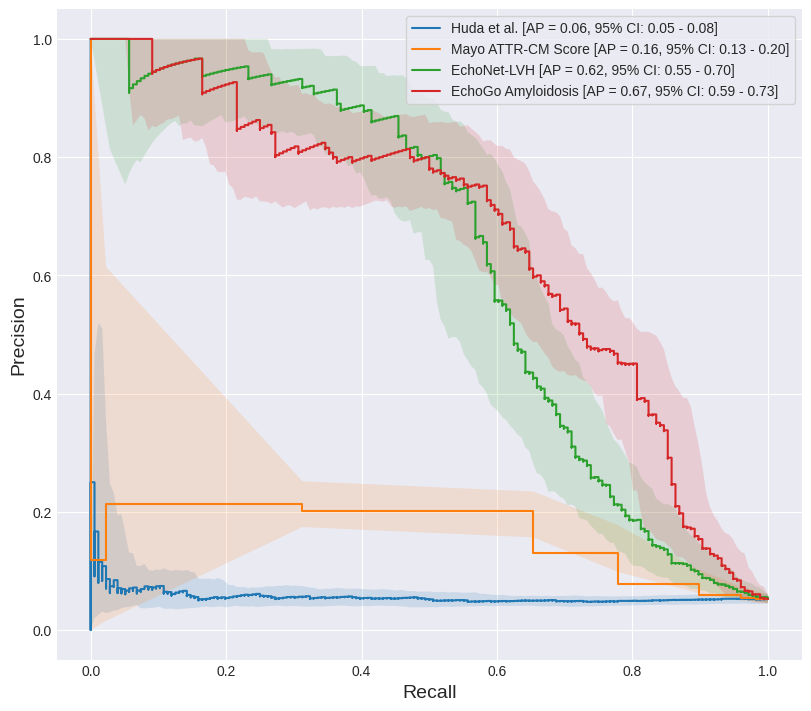

In [8]:
fig_pr = fig_pr_auc(
    cohort_tbl_3,
    conf_int=table3_perf.loc[
        ["\pfizertable", "\mayotable", "\enettable", "\\ulttable"], "ap_CI"
    ],
    FIGDST = FIG_OUT_PATH,
)

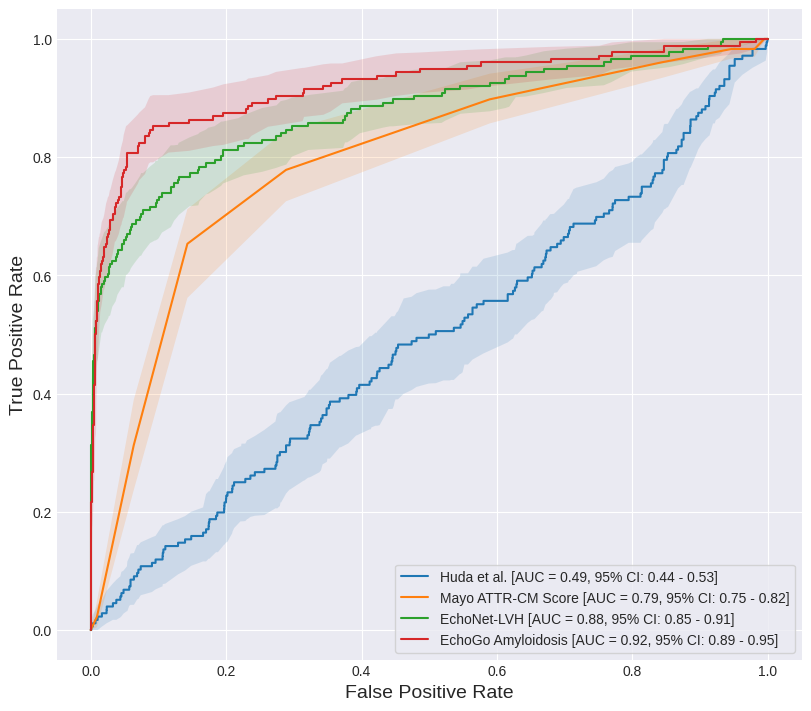

In [8]:
fig_roc = fig_roc_auc(
    cohort_tbl_3,
    conf_int=table3_perf.loc[
        ["\pfizertable", "\mayotable", "\enettable", "\\ulttable"], "auc_CI"
    ],
    FIGDST = FIG_OUT_PATH,
)

## Supplemental Table 3

Pfizer performance on patients with more than 50 encounters

In [26]:
enc50 = pd.read_csv("~/projects/aha_risk/src/pts_gt_50_encounters.csv")

In [28]:
# Table 3: best chance pfizer
cohort_supp_tbl_3 = main_cohort[
    (main_cohort.encounter_gt_50)
    & (main_cohort.EF_fill_custom >= 40)
]

supp_tabel3_perf = pd.DataFrame(
    [
        compute_scores(
            y_true=cohort_supp_tbl_3.true_label.notna().values,
            y_pred=cohort_supp_tbl_3.pfizer_prediction.apply(lambda x: x >= 0.5).values,
            y_pred_proba=np.vstack(cohort_supp_tbl_3.pfizer_prediction_proba.values),
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
        )
    ],
    index=["\pfizertable"],
)
supp_tabel3_perf[
    [
        "f1_score",
        "accuracy",
        "sensitivity",
        "specificity",
        "ppv",
        "npv",
        "fnr",
        "pr_auc",
        "roc_auc",
        "ap_CI",
        "auc_CI",
    ]
].round(2)

,f1_score,accuracy,sensitivity,specificity,ppv,npv,fnr,pr_auc,roc_auc,ap_CI,auc_CI
\pfizertable,0.21,0.61,0.43,0.63,0.14,0.89,0.57,0.19,0.56,"[0.13, 0.26]","[0.5, 0.62]"


In [ ]:
prevalence(cohort_supp_tbl_3)

N=861 (12.3%)
label__amyloid_subtype_diagnosis
None    755
TTR     106
Name: count, dtype: int64


In [ ]:
label1 = "Matched cohort"
col1 = FloatVector(np.vstack(cohort_tbl_3.loc[cohort_tbl_3.pfizer_prediction_proba.notna(), "pfizer_prediction_proba"].values)[:, 1])
true1 = IntVector(cohort_tbl_3.loc[cohort_tbl_3.pfizer_prediction_proba.notna(), "true_label"].notna().values.astype(
        int
    ))

label2 = "50 encounters"
col2 = FloatVector(np.vstack(cohort_supp_tbl_3.pfizer_prediction_proba.values)[:, 1])
true2 = IntVector(cohort_supp_tbl_3.true_label.notna().values.astype(
        int
    ))
roc1 = pROC.roc(true1, col1, quiet=True)
roc2 = pROC.roc(true2, col2, quiet=True)
Rdelong = pROC.roc_test(roc1, roc2, paried=False, method="delong", alternative="two.sided")

print(f"Delong Roc Test between {label1} and {label2}: {Rdelong.rx2('p.value')[0]:.4f}")

Delong Roc Test between Matched cohort and 50 encounters: 0.0840


## Supplemental Table 5

Missing EchoNet-LVH and EchoGo Ultromics predictions are filled with 0. Proba columns are then [1, 0].

In [31]:
supp_tbl_5_perf = pd.DataFrame(
    [
        # Pfizer Model
        compute_scores(
            y_true=main_cohort.true_label.notna().values,
            y_pred=main_cohort.pfizer_pred_filled_0.apply(lambda x: x[1] >= 0.5).values,
            y_pred_proba=np.vstack(main_cohort.pfizer_pred_filled_0.values),
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
        ),
        # Mayo ATTR-CM Score
        compute_scores(
            y_true=main_cohort.true_label.notna().values,
            y_pred=main_cohort.mayo_score.apply(lambda x: x >= 6).values,
            y_pred_proba=np.vstack(
                [
                    np.zeros_like(main_cohort.mayo_score.values),
                    main_cohort.mayo_score.values,
                ]
            ).T,
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
        ),
        # EchoNet-LVH
        compute_scores(
            y_true=main_cohort.true_label.notna().values,
            y_pred=main_cohort.amyloid_pred_filled_0.apply(lambda x: x >= 0.8).values,
            y_pred_proba=np.vstack(main_cohort.enet_preds_proba_filled_0.values),
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
        ),
        # Ultromics EchoGO
        compute_scores(
            y_true=main_cohort.true_label.notna().values,
            y_pred=(
                main_cohort.ultromics_classification
                == "DetectedAmyloidosis"
            ).values,
            y_pred_proba=np.vstack(main_cohort.ult_filled_0_preds_proba.values),
            auc_conf=(2.5, 97.5),
            ap_conf=(2.5, 97.5),
        ),
    ],
    index=[
        "\pfizertable",
        "\mayotable",
        "\enettable_0",
        r"\ulttable_0",
    ],
)
supp_tbl_5_perf[
    [
        "f1_score",
        "accuracy",
        "sensitivity",
        "specificity",
        "ppv",
        "npv",
        "fnr",
        "pr_auc",
        "ap_CI",
        "roc_auc",
        "auc_CI",
    ]
].round(2)

,f1_score,accuracy,sensitivity,specificity,ppv,npv,fnr,pr_auc,ap_CI,roc_auc,auc_CI
\pfizertable,0.08,0.66,0.30,0.68,0.05,0.95,0.70,0.05,"[0.04, 0.06]",0.48,"[0.44, 0.51]"
\mayotable,0.28,0.84,0.63,0.85,0.18,0.98,0.37,0.14,"[0.12, 0.17]",0.78,"[0.75, 0.81]"
\enettable_0,0.54,0.96,0.47,0.99,0.65,0.97,0.53,0.51,"[0.45, 0.58]",0.76,"[0.72, 0.8]"
\ulttable_0,0.45,0.91,0.74,0.92,0.33,0.99,0.26,0.59,"[0.52, 0.66]",0.82,"[0.78, 0.86]"


In [ ]:
prevalence(main_cohort)

# Pairwise DeLong ROC test
for (label1, col1), (label2, col2) in combinations(
    [
        ("Mayo", main_cohort.mayo_score.values),
        ("Echonet_0", main_cohort.amyloid_pred_filled_0),
        ("Ultromics_0", main_cohort.ult_filled_0),
    ],
    2,
):
    true1 = IntVector(main_cohort.true_label.notna().values.astype(
            int
        )
    )
    roc1 = pROC.roc(true1, FloatVector(col1), quiet=True)
    roc2 = pROC.roc(true1, FloatVector(col2), quiet=True)

    Rdelong = pROC.roc_test(
        roc1, roc2, paried=True, method="delong", alternative="two.sided"
    )

    print(
        f"Delong Roc Test between {label1} and {label2}: {Rdelong.rx2('p.value')[0]:.5}"
    )

N=4800 (5.0%)
label__amyloid_subtype_diagnosis
None    4560
TTR      240
Name: count, dtype: int64
Delong Roc Test between Mayo and Echonet_0: 0.44134
Delong Roc Test between Mayo and Ultromics_0: 0.052496
Delong Roc Test between Echonet_0 and Ultromics_0: 0.02053
